# Signal trading

Implementation:
1. Illustrative example of signal trading through turtle trading signal and moving average trading signal

2. Buy-and-hold strategy (This strategy will be used as the benchmark of the factor Neural Network strategy)

Illustration done for one stock and then for the universe of stocks split equally (4 stocks in the current illustration case)

Transaction costs are included as a percentage of volume. 
Amount to invest are split equally among the allocated funds

## 1. load the libraries and constants

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os

SOURCE_FOLDER = 'Data-processed'
TARGET_FOLDER = 'Data-factor'

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"

INVESTMENT = 10000  # value of fund to divide into x stocks
TRANSACTION_COSTS = 0.001  # 0.1% percent transaction costs 

## 2. load the data

In [137]:
# Use only the time-series and the static dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)

# trading signal
df_signal_ma = pd.read_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'moving_average_signal.csv'), encoding='utf-8',index_col=0)
df_turtle = pd.read_csv(os.path.join(os.getcwd(),TARGET_FOLDER, 'turtle_signal.csv'), encoding='utf-8',index_col=0)

## 3. Signal trading

In [122]:
# Presentation to buy the stock and illustrate
def buy_stock(real_movement,
              signal,
              initial_money = INVESTMENT,
              max_buy = 1,
              max_sell = 1,
              transac_costs =0,
              verbose=False):
    """
    real_movement = Stock price time-series - pandas dataframe
    signal = Buy/Sell signals - pandas dataframe
    initial_money: Value of funds to invest (unitary monetary value, i.e. USD)
    max_buy : Quantity to buy at each positive signal
    max_sell : Quantity to sell at each negative signal
    transac_costs :  Transaction costs at each transaction
    verbose: display print out. 
    """
    starting_money = initial_money  # Store the money allocated for the asset under review
    states_sell = []  # index at which a sell occurs
    states_buy = []  # index at which a buy occurs
    current_inventory = 0  # inventory of the stocks (Check that we don't invest all)
    return_array =[]  # reaturn value from the previous buy position # TO SUPPRESS
    dates_buy = []  # Dates of buy transaction
    dates_sell = []  # Dates of sell transaction
    return_ts =[]  # value of the investment per day - cash and current market value of stockss
    
    def buy(i, initial_money, current_inventory):
        """
        Implement the buy signal
        i: position index - get the date of the index
        initial_money: Cash amount available at t
        current_inventory: inventory of stock - positive integer
        """
        shares = initial_money // real_movement[i]  # Get the number available (floor int)
#         print("Value money", initial_money)
#         print( "Stock", np.isnan(real_movement[i]))
#         print( "Stock", real_movement.index[i])
#         print( "Nb shares", shares)
        if shares < 1:
            if verbose:
                print('day nb %d -date %s: total balances %f, not enough money to buy a unit price %f'
                    % (i, real_movement.index[i],  initial_money, real_movement[i]))
        else:
            if shares > max_buy:  # Buy the nb max of shares per new signal
                buy_units = max_buy
            else:
                buy_units = shares  # Buy the remaining shares
            initial_money -= buy_units * real_movement[i]  * (1 - transac_costs)  # Decrease the amount of money
            current_inventory += buy_units  # Increase the inventory
            if verbose:
                print('day nb %d -date %s: buy %d units at price %f, total balance %f'
                    % (i, real_movement.index[i], buy_units, buy_units * real_movement[i], initial_money))
            #states_buy.append(0)  # Flag buy stock states_buy.append(i) but elsewhere
        return initial_money, current_inventory
    
    # Loop over the time index
    for i in range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])):
        if np.isnan(real_movement[i]): 
            continue
        state = signal[i]  # Collec
        if state == 1: # signal to increase position - buy 
            # Check if value is NaN to avoid crash
            if not np.isnan(real_movement[i]): 
                initial_money, current_inventory = buy(i, initial_money, current_inventory)
                states_buy.append(i)
                dates_buy.append(real_movement.index[i])
        elif state == -1: # signal to decrease position - sell 
            if not np.isnan(real_movement[i]): 
                if current_inventory == 0:
                        if verbose:
                            print('day nb %d -date %s: cannot sell anything, inventory 0' % (i, real_movement.index[i]))
#                         print(i)
#                         print(real_movement.index[i])
#                         print("Value money", initial_money)
#                         print( "Stock", np.isnan(real_movement[i]))
#                         print( "Stock", real_movement.index[i])
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell  # Adjust from maximum selling
                    else:
                        sell_units = current_inventory  # Reduce to zero
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]  * (1 - transac_costs)  # amount minus costs
                    initial_money += total_sell  # add back to the pot
                    try:
                        # rate of return from the last buy position: states_buy[-1]
                        invest = (  
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                        # Other method - current value of inventory but that has to be at each period. 
                    except:
                        invest = 0
                    # Compute the return of investment so far - Stack invest.
                    if invest > 1:
                        if verbose:
                            print("invest",invest)
                            print("position",i)
                            print("Date",real_movement.index[i])
                            print("Value money end", real_movement[i])
                            print("Value money start", real_movement[states_buy[-1]])
                            print( "Position start", states_buy[-1])
                        
                    return_array.append(invest)
                    if verbose:
                        print('day nb %d -date %s, sell %d units at price %f, investment %f %%, total balance %f,'
                            % (i, real_movement.index[i], sell_units, total_sell, invest, initial_money))
                    states_sell.append(i)
                    dates_sell.append(real_movement.index[i])
                    
        # Out the return of the investment independent of trading operations. 
#         print(initial_money,starting_money,current_inventory, real_movement.index[i], real_movement[i], 
#              initial_money + current_inventory * real_movement[i],
#              (initial_money + current_inventory * real_movement[i] - starting_money)/starting_money) 
        # return w.r.t to the initial period. 
#         return_ts.append([real_movement.index[i],
#                           (initial_money + current_inventory * real_movement[i] - starting_money)/starting_money
#                          ])
        
        return_ts.append([real_movement.index[i],
                          initial_money + current_inventory * real_movement[i]
                         ])
#                   print("end",i)
#                     print("end",real_movement.index[i])
#                     print("Value money", initial_money)
#                     print( "Stock", np.isnan(real_movement[i]))
#                     print( "Stock", real_movement.index[i])

    # After trading we need to close the position
    if current_inventory>0:
        total_sell = current_inventory * real_movement[
            max(range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])))]   * (1 - transac_costs)
        initial_money += total_sell  # add back to the pot
        current_inventory = 0
#     print(real_movement[max(range(real_movement.shape[0] - int(0.025 * real_movement.shape[0])))])
#     print(current_inventory)
#     print(initial_money)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return {"buy": states_buy,
            "sell": states_sell,
            "dates_buy": dates_buy,
            "dates_sell": dates_sell,
            "gains": total_gains,
            "invest":invest,
            "returns":return_array, 
            "returns_ts":return_ts}

In [165]:
def f_drawdown(returns):
    """
    Output the drawdown time series dataframe from the returns dataframe of an investment
    """
    cum_returns = (1 + returns).cumprod()
    return  1 - cum_returns.div(cum_returns.cummax())

def sharpe_ratio(returns):
    """
    Output the Sharpe ratio from the returns dataframe
    """
    return returns.mean() / returns.std()

### Execution for one stock with the turtle trading signal

Value of gains:  326.95000000001164 3.2695000000001166


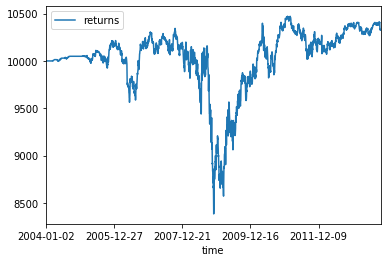

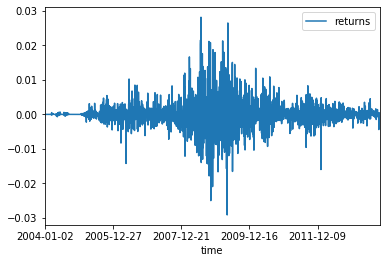

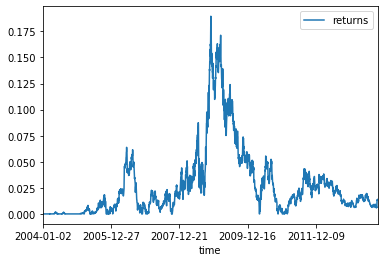

In [183]:
# Execution with turtle for one stock
array = buy_stock(df_data['PA1436583006-P'], df_turtle['PA1436583006-FTURTLE'], verbose = False)
print('Value of gains: ', array['gains'], array['invest'] )
# Value of investments
pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).plot()
# Returns of investments
pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1).plot()
# time serie of the drawdown
f_drawdown(pd.DataFrame(array['returns_ts'], columns=['time', 'returns']).set_index(['time']).pct_change(1)).plot()

In [180]:
# Metrics
# Sharpe Ratio
print('Sharpe ratio: ', sharpe_ratio(pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1)))
# Max drawdown
ts_drawdown =f_drawdown(pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1))
print('Max drawdown: ', ts_drawdown.max())
print('Date Max drawdown: ', ts_drawdown.idxmax())

Sharpe ratio:  returns    0.005349
dtype: float64
Max drawdown:  returns    0.18947
dtype: float64
Date Max drawdown:  returns    2008-11-20
dtype: object


### Execution for one stock with the moving average trading signal

Value of gains:  144.28499999998894 1.4428499999998894


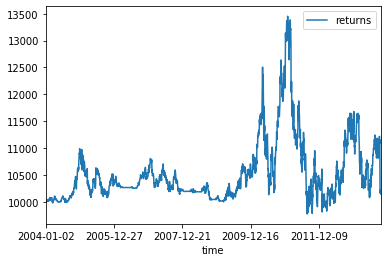

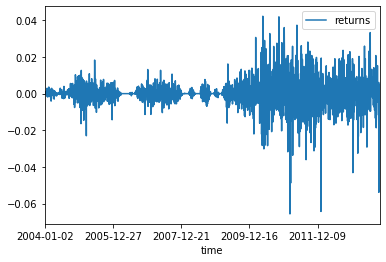

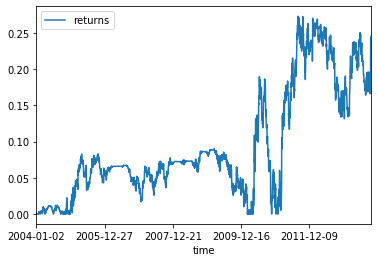

In [181]:
# Execution with Moving Average for one stock 
array = buy_stock(df_data['PA1436583006-P'], df_signal_ma['PA1436583006-FMA'], verbose = False)
print('Value of gains: ', array['gains'], array['invest'] )
# Value of investments
pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).plot()
# Returns of investments
pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1).plot()
# time serie of the drawdown
f_drawdown(pd.DataFrame(array['returns_ts'], columns=['time', 'returns']).set_index(['time']).pct_change(1)).plot()

In [182]:
# Metrics
# Sharpe Ratio
print('Sharpe ratio: ', sharpe_ratio(pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1)))
# Max drawdown
ts_drawdown =f_drawdown(pd.DataFrame(array['returns_ts'],
             columns=['time', 'returns']).set_index(['time']).pct_change(1))
print('Max drawdown: ', ts_drawdown.max())
print('Date Max drawdown: ', ts_drawdown.idxmax())

Sharpe ratio:  returns    0.004551
dtype: float64
Max drawdown:  returns    0.273486
dtype: float64
Date Max drawdown:  returns    2011-08-10
dtype: object


### Execution for all stocks with the moving average trading signal

In [184]:
# Multiple execution - moving average signal
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0] 
invest = INVESTMENT // NB_STOCKS# slipt the amount invested
print('Value invesed per stock: ',invest)
out  = [ buy_stock(df_data["-".join([isin,"P"])],
                   df_signal_ma["-".join([isin,"FMA"])],transac_costs=TRANSACTION_COSTS,
                   initial_money=invest, verbose = False) for isin in df_desc[df_desc['TYPE'] == 'Equity'].index ]
print('number of stocks: ', len(out))

pd_out = [pd.DataFrame(out[isin_index]['returns_ts'],
             columns=['time', 'returns']).set_index(['time']) for isin_index in range(len(signal))]

Value invesed per stock:  2500
number of stocks:  4


In [186]:
# Output the time series aggregated value of the investement for the x stocks
pd_out_total = pd.concat(pd_out, axis=1, sort=False).sum(axis=1).to_frame()
pd_out_total.columns = ['returns']
pd_out_total.head()

,returns
time,
2004-01-02,10000.135630
2004-01-05,10001.822055
2004-01-06,10002.786820
2004-01-07,10002.651505
2004-01-08,10005.716930


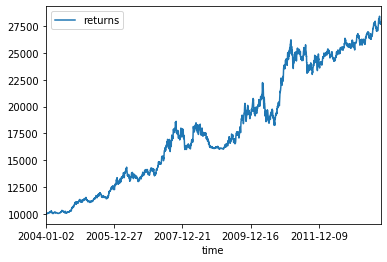

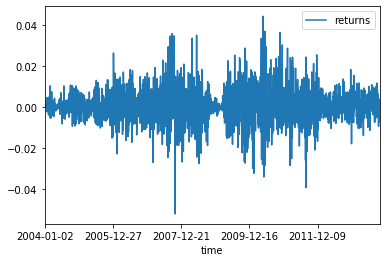

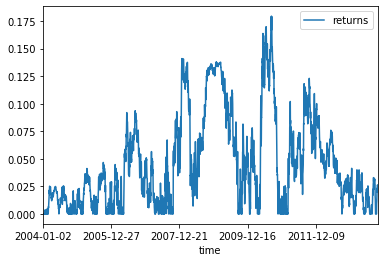

In [192]:
#Plot the value of the returns and the value of the funds. 
pd_out_total.plot()
pd_out_total.pct_change(1).plot()
f_drawdown(pd_out_total.pct_change(1)).plot()

In [193]:
# Metrics
# Sharpe Ratio
print('Sharpe ratio: ', sharpe_ratio(pd_out_total.pct_change(1)))
# Max drawdown
print('Max drawdown: ', f_drawdown(pd_out_total.pct_change(1)).max())
print('Date Max drawdown: ', f_drawdown(pd_out_total.pct_change(1)).idxmax())

Sharpe ratio:  returns    0.055314
dtype: float64
Max drawdown:  returns    0.179397
dtype: float64
Date Max drawdown:  returns    2010-08-26
dtype: object


### Execution for all stocks with the turtle trading signal

In [194]:
# Multiple execution  - turtle signal
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0] 
invest = INVESTMENT // NB_STOCKS# slipt the amount invested
print('Value invesed per stock: ',invest)
signal = [buy_stock(df_data["-".join([isin,"P"])],
                    df_turtle["-".join([isin,"FTURTLE"])],
                    initial_money=invest,transac_costs=TRANSACTION_COSTS, verbose = False) 
     for isin in df_desc[df_desc['TYPE'] == 'Equity'].index]
print('number of stocks: ', len(signal))
pd_signal = [pd.DataFrame(signal[isin_index]['returns_ts'],
             columns=['time', 'returns']).set_index(['time']) for isin_index in range(len(signal))]

Value invesed per stock:  2500
number of stocks:  4


In [195]:
# Summation of the different assets into one fund to compute the metrics
pd_signal_total = pd.concat(pd_signal, axis=1, sort=False).sum(axis=1).to_frame()
pd_signal_total.columns = ['returns']
pd_signal_total.head()

,returns
time,
2004-01-02,10000.0
2004-01-05,10000.0
2004-01-06,10000.0
2004-01-07,10000.0
2004-01-08,10000.0


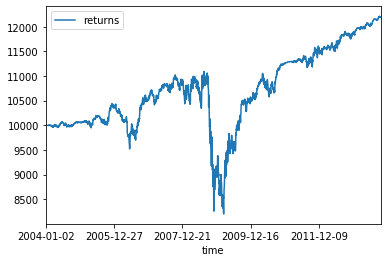

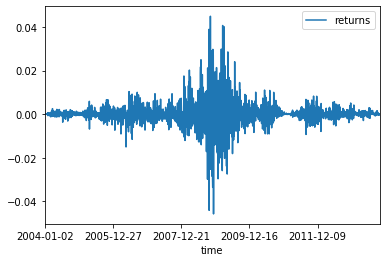

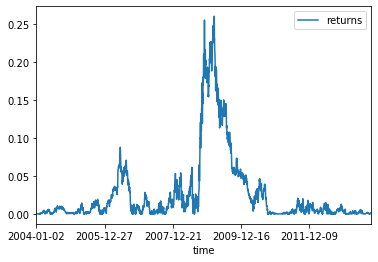

In [198]:
#Plot the value of the returns and the value of the funds. 
pd_signal_total.plot()
pd_signal_total.pct_change(1).plot()
f_drawdown(pd_signal_total.pct_change(1)).plot()

In [197]:
# Metrics
# Sharpe Ratio
print('Sharpe ratio: ', sharpe_ratio(pd_signal_total.pct_change(1)))
# Max drawdown
print('Max drawdown: ', f_drawdown(pd_signal_total.pct_change(1)).max())
print('Date Max drawdown: ', f_drawdown(pd_signal_total.pct_change(1)).idxmax())

Sharpe ratio:  returns    0.01785
dtype: float64
Max drawdown:  returns    0.260669
dtype: float64
Date Max drawdown:  returns    2009-03-09
dtype: object
